In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [108]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\Titanic'
train = pd.read_csv(os.path.join(project_path, r'data\train.csv')).set_index('PassengerId')
test = pd.read_csv(os.path.join(project_path, r'data\test.csv')).set_index('PassengerId')

In [109]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [110]:
train = train.drop(['Name','Ticket','Cabin'], axis=1)
test = test.drop(['Name','Ticket','Cabin'], axis=1)

## Train Test Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(train, train['Survived'], test_size=0.2, random_state=1)  

In [112]:
X_train.head()
X_train.info()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
302,1,3,male,NaN,2,0,23.2500,Q
310,1,1,female,30.0,0,0,56.9292,C
517,1,2,female,34.0,0,0,10.5000,S
121,0,2,male,21.0,2,0,73.5000,S
571,1,2,male,62.0,0,0,10.5000,S


<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 302 to 38
Data columns (total 8 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Sex         712 non-null object
Age         568 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    710 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


## Variables types

In [113]:
num_vars = [var for var in X_train.columns if X_train[var].dtypes != 'O' and 'Survived' not in var]
discrete_vars = [var for var in num_vars if X_train[var].nunique() <= 20]
num_vars = [var for var in num_vars if var not in discrete_vars]
cat_vars = [var for var in X_train.columns if X_train[var].dtypes == 'O']

print('Numeric variables: ', num_vars)
print('Discrete variables: ', discrete_vars)
print('Categorical variables: ', cat_vars)

Numeric variables:  ['Age', 'Fare']
Discrete variables:  ['Pclass', 'SibSp', 'Parch']
Categorical variables:  ['Sex', 'Embarked']


## Missing values

In [114]:
cat_vars_with_na = [col for col in cat_vars if (train[col].isnull().sum() > 0) or (test[col].isnull().sum() > 0)]
train[cat_vars_with_na].isnull().mean().sort_values(ascending=False)
print(cat_vars_with_na)

Embarked    0.002245
dtype: float64

['Embarked']


In [115]:
X_train['Embarked'].isnull().sum()
X_test['Embarked'].isnull().sum()
test['Embarked'].isnull().sum()

2

0

0

In [116]:
print(X_train.shape)
pass_to_delete = X_train[X_train['Embarked'].isnull()].index
y_train = y_train.drop(pass_to_delete, axis=0)
X_train = X_train[~(X_train['Embarked'].isnull())]
print(X_train.shape)
print(y_train.shape)

(712, 8)
(710, 8)
(710,)


In [117]:
num_vars_with_na = [col for col in num_vars if (train[col].isnull().sum() > 0) or (test[col].isnull().sum() > 0)]
print(X_train[num_vars_with_na].isnull().mean().sort_values(ascending=False))
print(X_test[num_vars_with_na].isnull().mean().sort_values(ascending=False))
print(test[num_vars_with_na].isnull().mean().sort_values(ascending=False))

Age     0.202817
Fare    0.000000
dtype: float64
Age     0.184358
Fare    0.000000
dtype: float64
Age     0.205742
Fare    0.002392
dtype: float64


In [118]:
for var in num_vars_with_na:
    var_median = X_train[var].median()
    X_train[var] = X_train[var].fillna(var_median)
    X_test[var] = X_test[var].fillna(var_median)
    test[var] = test[var].fillna(var_median)

In [119]:
print(X_train[num_vars_with_na].isnull().mean().sort_values(ascending=False))
print(X_test[num_vars_with_na].isnull().mean().sort_values(ascending=False))
print(test[num_vars_with_na].isnull().mean().sort_values(ascending=False))

Fare    0.0
Age     0.0
dtype: float64
Fare    0.0
Age     0.0
dtype: float64
Fare    0.0
Age     0.0
dtype: float64


In [120]:
discrete_vars_with_na = [col for col in discrete_vars if (train[col].isnull().sum() > 0) or (test[col].isnull().sum() > 0)]
print(X_train[discrete_vars_with_na].isnull().mean().sort_values(ascending=False))
print(X_test[discrete_vars_with_na].isnull().mean().sort_values(ascending=False))
print(test[discrete_vars_with_na].isnull().mean().sort_values(ascending=False))

Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)


In [121]:
[col for col in X_train.columns if X_train[col].isnull().sum() > 0]
[col for col in X_test.columns if X_test[col].isnull().sum() > 0]
[col for col in test.columns if test[col].isnull().sum() > 0]

[]

[]

[]

## Numerical variables

In [122]:
num_vars

['Age', 'Fare']

In [123]:
for df in [X_train, X_test, test]:
    df['Age_Bucket'] = pd.cut(df['Age'], bins=[0,18,25,30,40,80])
    df['Fare_Bucket'] = pd.cut(df['Fare'], bins=[-0.01,10,15,25,40,75,513])

In [124]:
test['Age'].max()
test['Fare'].max()

76.0

512.3292

In [125]:
X_train['Fare_Bucket'].value_counts()

(-0.01, 10.0]    270
(25.0, 40.0]     124
(10.0, 15.0]      95
(15.0, 25.0]      82
(75.0, 513.0]     79
(40.0, 75.0]      60
Name: Fare_Bucket, dtype: int64

In [126]:
age_mapping = {'(0, 18]': '0-18',
              '(18, 25]': '18-25',
              '(25, 30]': '25-30',
              '(30, 40]': '30-40',
              '(40, 80]': '40-80'}

fare_mapping = {'(-0.01, 10.0]': '0-10',
               '(10.0, 15.0]': '10-15',
               '(15.0, 25.0]': '15-25',
               '(25.0, 40.0]': '25-40',
               '(40.0, 75.0]': '40-75',
               '(75.0, 513.0]': '75-513'}

for df in [X_train, X_test, test]:
    df['Age_Bucket'] = df['Age_Bucket'].astype(str).map(age_mapping)
    df['Fare_Bucket'] = df['Fare_Bucket'].astype(str).map(fare_mapping)

In [127]:
X_train['Age_Bucket'].value_counts()
X_train['Fare_Bucket'].value_counts()

25-30    223
30-40    127
18-25    126
40-80    125
0-18     109
Name: Age_Bucket, dtype: int64

0-10      270
25-40     124
10-15      95
15-25      82
75-513     79
40-75      60
Name: Fare_Bucket, dtype: int64

In [128]:
pt = PowerTransformer()
X_train[num_vars] = pt.fit_transform(X_train[num_vars])
X_test[num_vars] = pt.transform(X_test[num_vars])
test[num_vars] = pt.transform(test[num_vars])

#X_train[num_vars] = np.log1p(X_train[num_vars])
#X_test[num_vars] = np.log1p(X_test[num_vars])
#test[num_vars] = np.log1p(test[num_vars])

In [129]:
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Bucket,Fare_Bucket
PassengerId,,,,,,,,,,
302,1,3,male,-0.017326,2,0,0.282050,Q,25-30,15-25
310,1,1,female,0.057272,0,0,1.134582,C,25-30,40-75
517,1,2,female,0.350944,0,0,-0.506659,S,30-40,10-15
121,0,2,male,-0.634488,2,0,1.368022,S,18-25,40-75
571,1,2,male,2.253449,0,0,-0.506659,S,40-80,10-15


# Discrete variables

In [130]:
for df in [X_train, X_test, test]:
    for var in ['SibSp','Parch']:
        df[var + '_'] = ''
        df[var + '_'] = np.where(df[var]==0, '0', df[var + '_'])
        df[var + '_'] = np.where(df[var].isin([1, 2]), '1-2', df[var + '_'])
        df[var + '_'] = np.where(df[var]>=3, '3andMore', df[var + '_'])
    df['Parch'] = df['Parch_']
    df['SibSp'] = df['SibSp_']
    

print(X_train['SibSp'].value_counts())
print(X_train['Parch'].value_counts())

0           481
1-2         197
3andMore     32
Name: SibSp, dtype: int64
0           539
1-2         160
3andMore     11
Name: Parch, dtype: int64


In [131]:
X_train = X_train.drop(['Parch_','SibSp_'], axis=1)
X_test = X_test.drop(['Parch_','SibSp_'], axis=1)
test = test.drop(['Parch_','SibSp_'], axis=1)

# Encode categorical variables

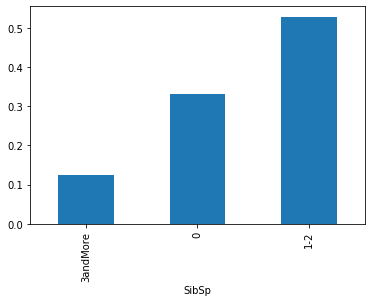

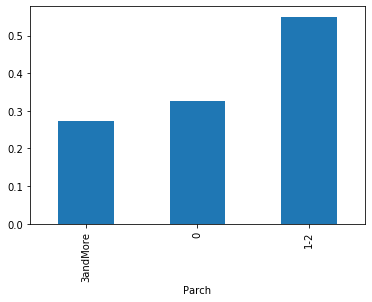

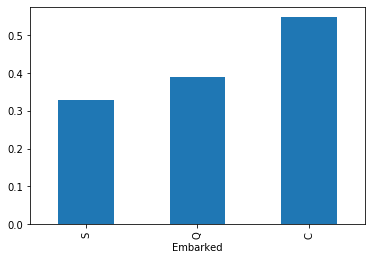

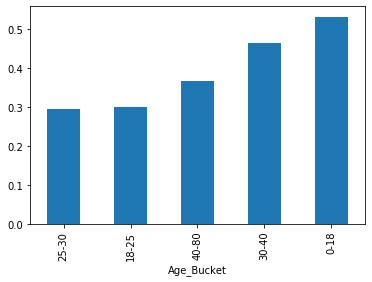

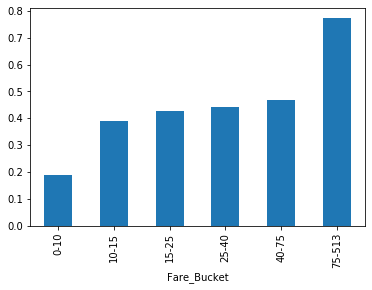

In [132]:
def encode_categories(train, test, test_lb, var):
    ordered_categories = train.groupby(var)['Survived'].mean().sort_values().index
    train.groupby(var)['Survived'].mean().sort_values(ascending=True).plot.bar()
    plt.show()
    ordered_labels = {k: i for i, k in enumerate(ordered_categories, 0)}
    train[var + '_enc'] = train[var].map(ordered_labels)
    test[var + '_enc'] = test[var].map(ordered_labels)
    test[var + '_enc'] = test[var + '_enc'].fillna(train[var + '_enc'].mode().iloc[0])
    test_lb[var + '_enc'] = test_lb[var].map(ordered_labels)
    test_lb[var + '_enc'] = test_lb[var + '_enc'].fillna(train[var + '_enc'].mode().iloc[0])
    
      
for var in ['SibSp','Parch','Embarked','Age_Bucket','Fare_Bucket']:
    encode_categories(X_train, X_test, test, var)

In [133]:
X_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Bucket,Fare_Bucket,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc
PassengerId,,,,,,,,,,,,,,,
302,1,3,male,-0.017326,1-2,0,0.282050,Q,25-30,15-25,2,1,1,0,2
310,1,1,female,0.057272,0,0,1.134582,C,25-30,40-75,1,1,2,0,4
517,1,2,female,0.350944,0,0,-0.506659,S,30-40,10-15,1,1,0,3,1
121,0,2,male,-0.634488,1-2,0,1.368022,S,18-25,40-75,2,1,0,1,4
571,1,2,male,2.253449,0,0,-0.506659,S,40-80,10-15,1,1,0,2,1


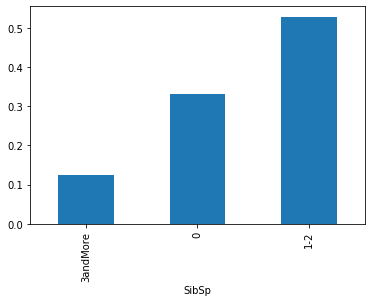

{'3andMore': 0.125, '0': 0.3305613305613306, '1-2': 0.5279187817258884}


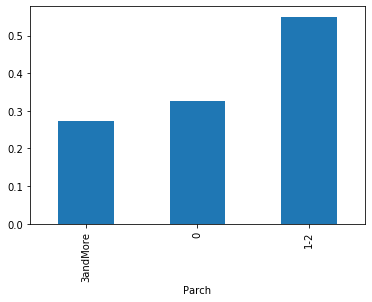

{'3andMore': 0.2727272727272727, '0': 0.32653061224489793, '1-2': 0.55}


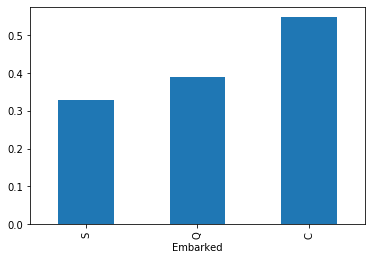

{'S': 0.32943469785575047, 'Q': 0.390625, 'C': 0.5488721804511278}


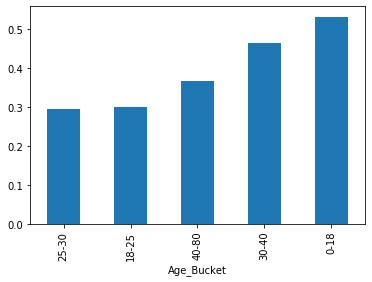

{'25-30': 0.29596412556053814, '18-25': 0.30158730158730157, '40-80': 0.368, '30-40': 0.4645669291338583, '0-18': 0.5321100917431193}


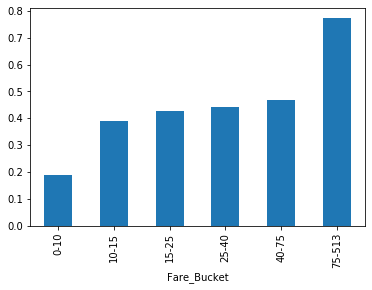

{'0-10': 0.18888888888888888, '10-15': 0.3894736842105263, '15-25': 0.4268292682926829, '25-40': 0.4435483870967742, '40-75': 0.4666666666666667, '75-513': 0.7721518987341772}


In [134]:
def encode_categories_with_median_target(train, test, test_lb, var):
    ordered_categories = train.groupby(var)['Survived'].mean().sort_values()
    train.groupby(var)['Survived'].mean().sort_values(ascending=True).plot.bar()
    plt.show()
    ordered_labels = ordered_categories.to_dict()
    print(ordered_labels)
   
    train[var + '_enc_%'] = train[var].map(ordered_labels)
    test[var + '_enc_%'] = test[var].map(ordered_labels)
    test[var + '_enc_%'] = test[var + '_enc_%'].fillna(train[var].mode().iloc[0])
    test_lb[var + '_enc_%'] = test_lb[var].map(ordered_labels)
    test_lb[var + '_enc_%'] = test_lb[var + '_enc_%'].fillna(train[var].mode().iloc[0])

for var in ['SibSp','Parch','Embarked','Age_Bucket','Fare_Bucket']:
    encode_categories_with_median_target(X_train, X_test, test, var)

In [135]:
X_train = pd.get_dummies(X_train, columns = ['Sex','SibSp','Parch','Embarked','Age_Bucket','Fare_Bucket'], drop_first=True)
X_test = pd.get_dummies(X_test, columns = ['Sex','SibSp','Parch','Embarked','Age_Bucket','Fare_Bucket'], drop_first=True)
test = pd.get_dummies(test, columns = ['Sex','SibSp','Parch','Embarked','Age_Bucket','Fare_Bucket'], drop_first=True)

In [136]:
X_train.head()

,Survived,Pclass,Age,Fare,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_enc_%,Parch_enc_%,Embarked_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,Sex_male,SibSp_1-2,SibSp_3andMore,Parch_1-2,Parch_3andMore,Embarked_Q,Embarked_S,Age_Bucket_18-25,Age_Bucket_25-30,Age_Bucket_30-40,Age_Bucket_40-80,Fare_Bucket_10-15,Fare_Bucket_15-25,Fare_Bucket_25-40,Fare_Bucket_40-75,Fare_Bucket_75-513
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
302,1,3,-0.017326,0.282050,2,1,1,0,2,0.527919,0.326531,0.390625,0.295964,0.426829,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
310,1,1,0.057272,1.134582,1,1,2,0,4,0.330561,0.326531,0.548872,0.295964,0.466667,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
517,1,2,0.350944,-0.506659,1,1,0,3,1,0.330561,0.326531,0.329435,0.464567,0.389474,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
121,0,2,-0.634488,1.368022,2,1,0,1,4,0.527919,0.326531,0.329435,0.301587,0.466667,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0
571,1,2,2.253449,-0.506659,1,1,0,2,1,0.330561,0.326531,0.329435,0.368000,0.389474,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0


In [137]:
X_test.head()

,Survived,Pclass,Age,Fare,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_enc_%,Parch_enc_%,Embarked_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,Sex_male,SibSp_1-2,SibSp_3andMore,Parch_1-2,Parch_3andMore,Embarked_Q,Embarked_S,Age_Bucket_18-25,Age_Bucket_25-30,Age_Bucket_30-40,Age_Bucket_40-80,Fare_Bucket_10-15,Fare_Bucket_15-25,Fare_Bucket_25-40,Fare_Bucket_40-75,Fare_Bucket_75-513
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
863,1,1,1.330375,0.388421,1,1,0,2,3,0.330561,0.326531,0.329435,0.368000,0.443548,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
224,0,3,-0.017326,-0.791303,1,1,0,0,0,0.330561,0.326531,0.329435,0.295964,0.188889,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
85,1,2,-0.959871,-0.506659,1,1,0,4,1,0.330561,0.326531,0.329435,0.532110,0.389474,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
681,0,3,-0.017326,-0.761259,1,1,1,0,0,0.330561,0.326531,0.390625,0.295964,0.188889,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
536,1,2,-1.853466,0.400375,1,2,0,4,3,0.330561,0.550000,0.329435,0.532110,0.443548,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0


In [138]:
test.head()

,Pclass,Age,Fare,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_enc_%,Parch_enc_%,Embarked_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,Sex_male,SibSp_1-2,SibSp_3andMore,Parch_1-2,Parch_3andMore,Embarked_Q,Embarked_S,Age_Bucket_18-25,Age_Bucket_25-30,Age_Bucket_30-40,Age_Bucket_40-80,Fare_Bucket_10-15,Fare_Bucket_15-25,Fare_Bucket_25-40,Fare_Bucket_40-75,Fare_Bucket_75-513
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,3,0.387157,-0.799739,1,1,1,3,0,0.330561,0.326531,0.390625,0.464567,0.188889,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
893,3,1.262519,-0.911009,2,1,0,2,0,0.527919,0.326531,0.329435,0.368000,0.188889,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
894,2,2.253449,-0.587179,1,1,1,2,0,0.330561,0.326531,0.390625,0.368000,0.188889,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
895,3,-0.168074,-0.698895,1,1,0,0,0,0.330561,0.326531,0.329435,0.295964,0.188889,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
896,3,-0.555107,-0.349526,2,2,0,1,1,0.527919,0.550000,0.329435,0.301587,0.389474,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0


In [139]:
X_train.shape
X_test.shape
test.shape

(710, 30)

(179, 30)

(418, 29)

In [140]:
X_train.isnull().sum().sum()
X_test.isnull().sum().sum()
test.isnull().sum().sum()

0

0

0

## Feature scaling

In [141]:
ss = StandardScaler()

X_train = X_train.drop('Survived', axis=1)
X_test = X_test.drop('Survived', axis=1)

X_train = pd.DataFrame(ss.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(ss.transform(X_test), columns = X_test.columns, index = X_test.index)
test = pd.DataFrame(ss.transform(test), columns=test.columns, index = test.index)
X_train.head()
X_test.head()
test.head()

,Pclass,Age,Fare,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_enc_%,Parch_enc_%,Embarked_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,Sex_male,SibSp_1-2,SibSp_3andMore,Parch_1-2,Parch_3andMore,Embarked_Q,Embarked_S,Age_Bucket_18-25,Age_Bucket_25-30,Age_Bucket_30-40,Age_Bucket_40-80,Fare_Bucket_10-15,Fare_Bucket_15-25,Fare_Bucket_25-40,Fare_Bucket_40-75,Fare_Bucket_75-513
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
302,0.833889,-0.017326,0.282050,1.481301,-0.473054,0.677858,-1.152788,0.122758,1.472110,-0.526577,0.171883,-0.887161,0.281248,0.730395,1.61371,-0.21725,-0.53936,-0.125446,3.177066,-1.61371,-0.464493,1.477788,-0.466732,-0.462250,-0.393029,2.767406,-0.460004,-0.303822,-0.353833
310,-1.563119,0.057272,1.134582,-0.448467,-0.473054,1.944384,-1.152788,1.254678,-0.441015,-0.526577,2.038906,-0.887161,0.501921,-1.369122,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,-1.61371,-0.464493,1.477788,-0.466732,-0.462250,-0.393029,-0.361349,-0.460004,3.291403,-0.353833
517,-0.364615,0.350944,-0.506659,-0.448467,-0.473054,-0.588667,0.905417,-0.443203,-0.441015,-0.526577,-0.550049,0.980409,0.074323,-1.369122,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,-0.676687,2.142557,-0.462250,2.544344,-0.361349,-0.460004,-0.303822,-0.353833
121,-0.364615,-0.634488,1.368022,1.481301,-0.473054,-0.588667,-0.466720,1.254678,1.472110,-0.526577,-0.550049,-0.824874,0.501921,0.730395,1.61371,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,2.152887,-0.676687,-0.466732,-0.462250,-0.393029,-0.361349,-0.460004,3.291403,-0.353833
571,-0.364615,2.253449,-0.506659,-0.448467,-0.473054,-0.588667,0.219349,-0.443203,-0.441015,-0.526577,-0.550049,-0.089238,0.074323,0.730395,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,-0.676687,-0.466732,2.163331,2.544344,-0.361349,-0.460004,-0.303822,-0.353833


,Pclass,Age,Fare,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_enc_%,Parch_enc_%,Embarked_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,Sex_male,SibSp_1-2,SibSp_3andMore,Parch_1-2,Parch_3andMore,Embarked_Q,Embarked_S,Age_Bucket_18-25,Age_Bucket_25-30,Age_Bucket_30-40,Age_Bucket_40-80,Fare_Bucket_10-15,Fare_Bucket_15-25,Fare_Bucket_25-40,Fare_Bucket_40-75,Fare_Bucket_75-513
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
863,-1.563119,1.330375,0.388421,-0.448467,-0.473054,-0.588667,0.219349,0.688718,-0.441015,-0.526577,-0.550049,-0.089238,0.373861,-1.369122,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,-0.676687,-0.466732,2.163331,-0.393029,-0.361349,2.173892,-0.303822,-0.353833
224,0.833889,-0.017326,-0.791303,-0.448467,-0.473054,-0.588667,-1.152788,-1.009163,-0.441015,-0.526577,-0.550049,-0.887161,-1.036783,0.730395,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,1.477788,-0.466732,-0.462250,-0.393029,-0.361349,-0.460004,-0.303822,-0.353833
85,-0.364615,-0.959871,-0.506659,-0.448467,-0.473054,-0.588667,1.591486,-0.443203,-0.441015,-0.526577,-0.550049,1.728568,0.074323,-1.369122,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,-0.676687,-0.466732,-0.462250,2.544344,-0.361349,-0.460004,-0.303822,-0.353833
681,0.833889,-0.017326,-0.761259,-0.448467,-0.473054,0.677858,-1.152788,-1.009163,-0.441015,-0.526577,0.171883,-0.887161,-1.036783,-1.369122,-0.61969,-0.21725,-0.53936,-0.125446,3.177066,-1.61371,-0.464493,1.477788,-0.466732,-0.462250,-0.393029,-0.361349,-0.460004,-0.303822,-0.353833
536,-0.364615,-1.853466,0.400375,-0.448467,1.781096,-0.588667,1.591486,0.688718,-0.441015,1.849438,-0.550049,1.728568,0.373861,-1.369122,-0.61969,-0.21725,1.85405,-0.125446,-0.314756,0.61969,-0.464493,-0.676687,-0.466732,-0.462250,-0.393029,-0.361349,2.173892,-0.303822,-0.353833


,Pclass,Age,Fare,SibSp_enc,Parch_enc,Embarked_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_enc_%,Parch_enc_%,Embarked_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,Sex_male,SibSp_1-2,SibSp_3andMore,Parch_1-2,Parch_3andMore,Embarked_Q,Embarked_S,Age_Bucket_18-25,Age_Bucket_25-30,Age_Bucket_30-40,Age_Bucket_40-80,Fare_Bucket_10-15,Fare_Bucket_15-25,Fare_Bucket_25-40,Fare_Bucket_40-75,Fare_Bucket_75-513
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,0.833889,0.387157,-0.799739,-0.448467,-0.473054,0.677858,0.905417,-1.009163,-0.441015,-0.526577,0.171883,0.980409,-1.036783,0.730395,-0.61969,-0.21725,-0.53936,-0.125446,3.177066,-1.61371,-0.464493,-0.676687,2.142557,-0.462250,-0.393029,-0.361349,-0.460004,-0.303822,-0.353833
893,0.833889,1.262519,-0.911009,1.481301,-0.473054,-0.588667,0.219349,-1.009163,1.472110,-0.526577,-0.550049,-0.089238,-1.036783,-1.369122,1.61371,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,-0.676687,-0.466732,2.163331,-0.393029,-0.361349,-0.460004,-0.303822,-0.353833
894,-0.364615,2.253449,-0.587179,-0.448467,-0.473054,0.677858,0.219349,-1.009163,-0.441015,-0.526577,0.171883,-0.089238,-1.036783,0.730395,-0.61969,-0.21725,-0.53936,-0.125446,3.177066,-1.61371,-0.464493,-0.676687,-0.466732,2.163331,-0.393029,-0.361349,-0.460004,-0.303822,-0.353833
895,0.833889,-0.168074,-0.698895,-0.448467,-0.473054,-0.588667,-1.152788,-1.009163,-0.441015,-0.526577,-0.550049,-0.887161,-1.036783,0.730395,-0.61969,-0.21725,-0.53936,-0.125446,-0.314756,0.61969,-0.464493,1.477788,-0.466732,-0.462250,-0.393029,-0.361349,-0.460004,-0.303822,-0.353833
896,0.833889,-0.555107,-0.349526,1.481301,1.781096,-0.588667,-0.466720,-0.443203,1.472110,1.849438,-0.550049,-0.824874,0.074323,-1.369122,1.61371,-0.21725,1.85405,-0.125446,-0.314756,0.61969,2.152887,-0.676687,-0.466732,-0.462250,2.544344,-0.361349,-0.460004,-0.303822,-0.353833


In [142]:
X_train.to_csv(os.path.join(project_path, r'data\X_train.csv'))
X_test.to_csv(os.path.join(project_path, r'data\X_test.csv'))
y_train.to_csv(os.path.join(project_path, r'data\y_train.csv'))
y_test.to_csv(os.path.join(project_path, r'data\y_test.csv'))
test.to_csv(os.path.join(project_path, r'data\test_lb.csv'))